### Moises Quiroz Diaz

# Preliminares

## Desafío 1: Determinantes del ingreso

Usted trabaja para un organismo no gubernamental que está interesado en las dinámicas
socioeconómicas que determinan la desigualdad de ingreso y la erradicación de la pobreza extrema,
enmarcado dentro de los objetivos del desarrollo del nuevo milenio del Programa de las Naciones
Unidas para el Desarrollo. Le encomiendan el desarrollo de un modelo predictivo sobre la
probabilidad que un individuo presente salarios por sobre o bajo los 50.000 dólares anuales, en base
a una serie de atributos sociodemográficos.

# Aspectos computacionales

Se importan las librerias con las hemos trabajado durante todos los cursos de data science, de momento las funciones a realizar son simplemente para limpiar y binarizar la data, ademas de posteriormente crear modelos de clasificacion tanto de la vision desde la econometria, como del machine-learning

In [1]:
import pandas as pd #Leer datafreme
import numpy as np #Vectores numericos
import statsmodels.api as sm
import statsmodels.formula.api as smf #Trabajo de modelos regresivos
import matplotlib.pyplot as plt #graficos
from scipy import stats #Metricas
import seaborn as sns #Graficos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score
import missingno as msngo
import warnings
warnings.filterwarnings("ignore")

#### Se trata de un problema de clasificacion, esto se observa por el tipo de vector objetivo que se nos presenta

# Descripción

##### Se procede a inspeccionar la data obtenida

In [2]:
df = pd.read_csv('income-db.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
df = df.replace('?',np.nan)
df = df.dropna()
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [4]:
df = df.drop(columns=['fnlwgt','educational-num'],axis=1)
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


##### Se realiza un analisis del contenido de las variables categoritas, de manera de procesarlas posteriormente

In [5]:
for i,j in df[['income','workclass','education','marital-status','occupation','relationship','race','gender','native-country']].iteritems():
    print('\ncolumna:',i+'\n'+str(j.value_counts('%')))


columna: income
<=50K    0.752156
>50K     0.247844
Name: income, dtype: float64

columna: workclass
Private             0.736522
Self-emp-not-inc    0.083941
Local-gov           0.068551
State-gov           0.043032
Self-emp-inc        0.036398
Federal-gov         0.031091
Without-pay         0.000464
Name: workclass, dtype: float64

columna: education
HS-grad         0.326898
Some-college    0.218898
Bachelors       0.167396
Masters         0.055592
Assoc-voc       0.043320
11th            0.035801
Assoc-acdm      0.033324
10th            0.027044
7th-8th         0.018199
Prof-school     0.017359
9th             0.014948
12th            0.012759
Doctorate       0.012030
5th-6th         0.009929
1st-4th         0.004909
Preschool       0.001592
Name: education, dtype: float64

columna: marital-status
Married-civ-spouse       0.465592
Never-married            0.322807
Divorced                 0.139246
Separated                0.031202
Widowed                  0.028238
Married-spouse-a

##### Se procede a renombrar las columnas

In [6]:
df = df.rename({'occupation':'collars','workclass':'workclass_recod','education':'educ_recod','marital-status':'civstatus','native-country':'region'},axis='columns')

In [7]:
df.columns

Index(['age', 'workclass_recod', 'educ_recod', 'civstatus', 'collars',
       'relationship', 'race', 'gender', 'capital-gain', 'capital-loss',
       'hours-per-week', 'region', 'income'],
      dtype='object')

###### Se procede reagrupar los datos

In [8]:
df['collars'] = df['collars'].replace(['Prof-specialty','Exec-managerial','Adm-clerical','Sales','Tech-support'],'white-collar')
df['collars'] = df['collars'].replace(['Craft-repair', 'Machine-op-inspct', 'Transport-moving','Handlers-cleaners', 'Farming-fishing', 'Protective-serv', 'Priv-house-serv'],'blue-collar')
df['collars'] = df['collars'].replace(['Other-service', 'Armed-Forces'],'other')
df['collars'].value_counts('%')

white-collar    0.538676
blue-collar     0.354695
other           0.106630
Name: collars, dtype: float64

In [9]:
df['workclass_recod'] = df['workclass_recod'].replace(['federal-gov'],'Federal-gov')
df['workclass_recod'] = df['workclass_recod'].replace(['State-gov', 'Local-gov'],'state-level-gov')
df['workclass_recod'] = df['workclass_recod'].replace(['Self-emp-inc', 'Self-emp-not-inc'],'self-employed')
df['workclass_recod'] = df['workclass_recod'].replace(['Never-worked', 'Without-pay'],'unemployed')
df.workclass_recod.value_counts('%')

Private            0.736522
self-employed      0.120340
state-level-gov    0.111583
Federal-gov        0.031091
unemployed         0.000464
Name: workclass_recod, dtype: float64

In [10]:
df['educ_recod'] = df['educ_recod'].replace(['Preschool'],'preschool')
df['educ_recod'] = df['educ_recod'].replace(['1st-4th', '5th-6th'],'elementary-school')
df['educ_recod'] = df['educ_recod'].replace(['7th-8th', '9th', '10th','11th', '12th', 'HS-grad'],'high-school')
df['educ_recod'] = df['educ_recod'].replace([ 'Assoc-voc', 'Assoc-acdm', 'Some-college'],'college')
df['educ_recod'] = df['educ_recod'].replace(['Bachelors', 'Masters', 'Prof-school', 'Doctorate'],'university')
df.educ_recod.value_counts('%')

high-school          0.435651
college              0.295542
university           0.252377
elementary-school    0.014838
preschool            0.001592
Name: educ_recod, dtype: float64

In [11]:
df['civstatus'] = df['civstatus'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],'married')
df['civstatus'] = df['civstatus'].replace(['Divorced'],'divorced')
df['civstatus'] = df['civstatus'].replace(['Separated'],'separated')
df['civstatus'] = df['civstatus'].replace(['Widowed'],'widowed')
df.civstatus.value_counts('%')

married          0.478506
Never-married    0.322807
divorced         0.139246
separated        0.031202
widowed          0.028238
Name: civstatus, dtype: float64

In [12]:
df['region'] = df['region'].replace(['Holand-Netherlands','Hungary','Scotland','Germany','England','Italy','Poland','Portugal','Greece','Ireland','France','Yugoslavia'],'Europa')
df['region'] = df['region'].replace(['Honduras','Outlying-US(Guam-USVI-etc)','United-States','Mexico','Puerto-Rico','Canada','El-Salvador','Cuba','Jamaica','Dominican-Republic','Guatemala','Columbia','Haiti','Nicaragua','Peru','Ecuador','Trinadad&Tobago'],'America')
df['region'] = df['region'].replace(['Laos','Philippines','India','China','South','Japan','Vietnam','Iran','Taiwan','Thailand','Hong','Cambodia'],'Asia')

df.region.value_counts('%')
# No se encontraron paises de otros continentes


America    0.960882
Asia       0.022799
Europa     0.016319
Name: region, dtype: float64

#### Se binarizar nuestro vector objetivo

In [13]:
df['income'] = df['income'].replace('<=50K', 0) 
df['income'] = df['income'].replace('>50K', 1)

In [14]:
df.income.value_counts('%')

0    0.752156
1    0.247844
Name: income, dtype: float64

##### Las metricas a utilizar para verificar la calidad del modelo, son las que se entreguen post ajuste del modelo, las obtenidas mediante el summary, ejemplo el R-square

###### Se procede a estudiar visualmente el vector objetivo, notando que la menor cantidad de personas son las con ingreso superior a los 50K

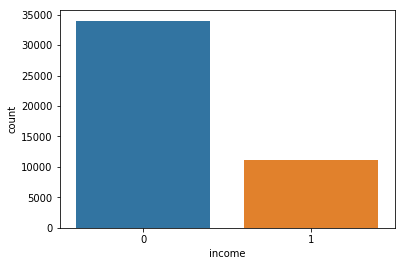

In [15]:
sns.countplot('income',data=df)

##### Se procede a evaluar las demas variables visualmente, 1ro enfocandose en el vector objetivos

In [16]:
categoricas = ['workclass_recod','educ_recod','civstatus','collars','relationship','race','gender','region']

income vs workclass_recod


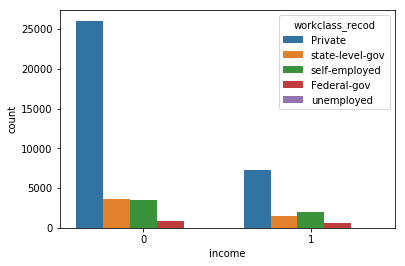

income vs educ_recod


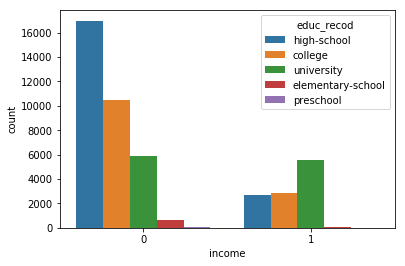

income vs civstatus


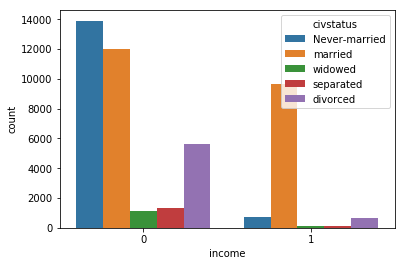

income vs collars


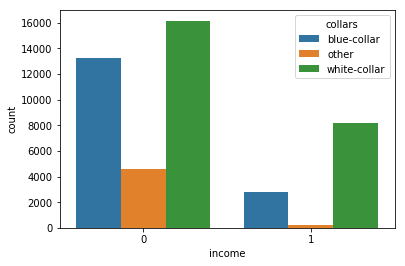

income vs relationship


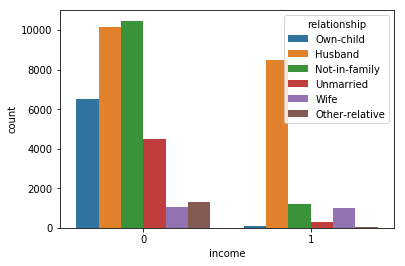

income vs race


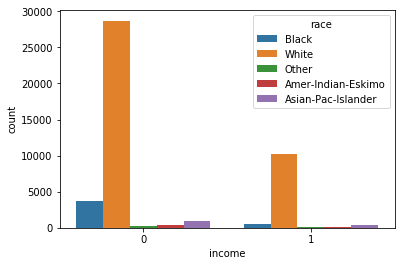

income vs gender


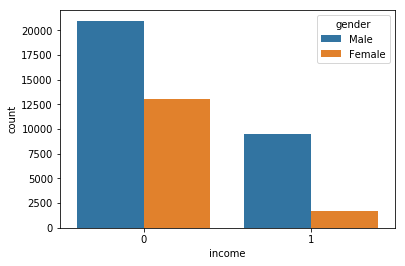

income vs region


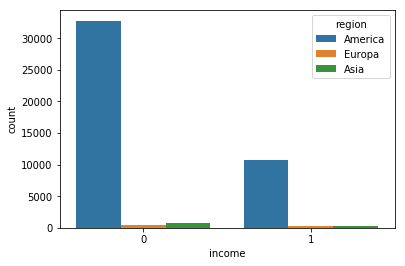

In [17]:
for i in categoricas:
    print('income vs',i)
    sns.countplot(x='income',hue=i,data=df)
    plt.show()  

##### Al comienzo se eliminaron los datos perdidos, por lo que se esperaba no existieran, de igual forma se procede a inspeccionar

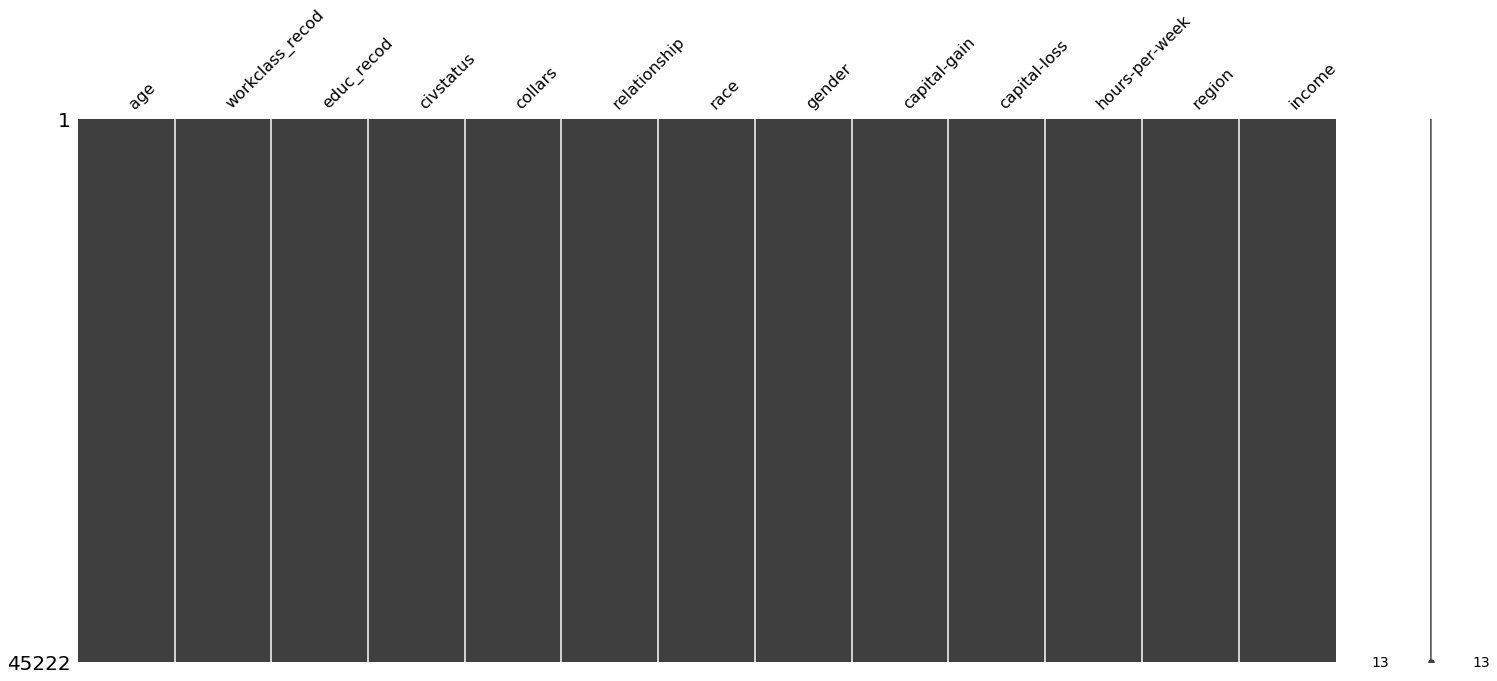

In [18]:
msngo.matrix(df)

In [19]:
df.head()

,age,workclass_recod,educ_recod,civstatus,collars,relationship,race,gender,capital-gain,capital-loss,hours-per-week,region,income
0,25,Private,high-school,Never-married,blue-collar,Own-child,Black,Male,0,0,40,America,0
1,38,Private,high-school,married,blue-collar,Husband,White,Male,0,0,50,America,0
2,28,state-level-gov,college,married,blue-collar,Husband,White,Male,0,0,40,America,1
3,44,Private,college,married,blue-collar,Husband,Black,Male,7688,0,40,America,1
5,34,Private,high-school,Never-married,other,Not-in-family,White,Male,0,0,30,America,0


* Se observa que existe un dataframe ordenado en base a los que se espera en la descripcion del problema, ademas se continua binarizando para poder ser tratado en los modelos computacionales

In [20]:
df['gender'] = df['gender'].replace('Male', 0) 
df['gender'] = df['gender'].replace('Female', 1)

* Se recorre el dateframe para observar las opciones que deben ser binarizadas

In [21]:
for i in df.columns:
    print('--------------------------')
    print('\nVariable:',i+'\n'+str(df[i].value_counts('%')))

--------------------------

Variable: age
36    0.028371
33    0.028283
31    0.028172
35    0.028128
23    0.027442
34    0.027288
37    0.027177
30    0.026867
38    0.026779
28    0.026492
32    0.026447
41    0.025961
39    0.025850
27    0.025585
29    0.025585
40    0.025297
25    0.025054
24    0.024988
42    0.024612
26    0.024148
43    0.023550
46    0.023484
45    0.023197
47    0.022953
44    0.022887
22    0.022865
21    0.020676
20    0.020256
19    0.019106
51    0.018464
        ...   
61    0.008713
62    0.007253
64    0.006302
63    0.006192
65    0.004799
66    0.003980
67    0.003980
68    0.003007
69    0.002565
70    0.002123
71    0.001990
72    0.001835
73    0.001813
74    0.001305
75    0.001172
76    0.001017
90    0.001017
77    0.000862
80    0.000641
81    0.000597
78    0.000464
79    0.000442
82    0.000221
83    0.000199
84    0.000199
85    0.000111
88    0.000111
86    0.000022
87    0.000022
89    0.000022
Name: age, Length: 74, dtype: float64
-----

# Modelacion Descriptiva

Se continuara binarizando la data, ahora con el objetivo de poder realizar regresion a cada modelo

In [22]:
df = pd.get_dummies(df,drop_first=True,columns=['workclass_recod','educ_recod','civstatus','collars','relationship','race','region'])
df.head()                   
                                 

,age,gender,capital-gain,capital-loss,hours-per-week,income,workclass_recod_Private,workclass_recod_self-employed,workclass_recod_state-level-gov,workclass_recod_unemployed,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,region_Asia,region_Europa
0,25,0,0,0,40,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,38,0,0,0,50,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,0,0,0,40,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,44,0,7688,0,40,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,34,0,0,0,30,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
#Se ejecuta un pequeño for para verificar que solo se traten de enteros, en caso de no retornar nada, todo es ok
for i in df.columns:
    for j in df[i]:
        if(type(j)!= int):
            print(j)

In [24]:
df.head()

,age,gender,capital-gain,capital-loss,hours-per-week,income,workclass_recod_Private,workclass_recod_self-employed,workclass_recod_state-level-gov,workclass_recod_unemployed,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,region_Asia,region_Europa
0,25,0,0,0,40,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,38,0,0,0,50,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,0,0,0,40,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,44,0,7688,0,40,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,34,0,0,0,30,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


##### Finalmente las columnas tratadas son

In [25]:
df.columns


Index(['age', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
       'income', 'workclass_recod_Private', 'workclass_recod_self-employed',
       'workclass_recod_state-level-gov', 'workclass_recod_unemployed',
       'educ_recod_elementary-school', 'educ_recod_high-school',
       'educ_recod_preschool', 'educ_recod_university', 'civstatus_divorced',
       'civstatus_married', 'civstatus_separated', 'civstatus_widowed',
       'collars_other', 'collars_white-collar', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',
       'region_Asia', 'region_Europa'],
      dtype='object')

#### Se procede a crear el modelo en base a las columnas

In [26]:
df.columns = df.columns.str.replace("-", "_")
df_saturado = df

In [27]:
lista = list(df.columns)
lista.remove('income')
modelo_str = ' + '.join(lista)
modelo_str = 'income ~ '+modelo_str
modelo_str

'income ~ age + gender + capital_gain + capital_loss + hours_per_week + workclass_recod_Private + workclass_recod_self_employed + workclass_recod_state_level_gov + workclass_recod_unemployed + educ_recod_elementary_school + educ_recod_high_school + educ_recod_preschool + educ_recod_university + civstatus_divorced + civstatus_married + civstatus_separated + civstatus_widowed + collars_other + collars_white_collar + relationship_Not_in_family + relationship_Other_relative + relationship_Own_child + relationship_Unmarried + relationship_Wife + race_Asian_Pac_Islander + race_Black + race_Other + race_White + region_Asia + region_Europa'

In [28]:
modelo = smf.logit(formula= modelo_str,data=df).fit()

Optimization terminated successfully.
         Current function value: 0.335615
         Iterations 11


In [29]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                45222
Model:                          Logit   Df Residuals:                    45191
Method:                           MLE   Df Model:                           30
Date:                Wed, 24 Jul 2019   Pseudo R-squ.:                  0.4006
Time:                        11:59:09   Log-Likelihood:                -15177.
converged:                       True   LL-Null:                       -25322.
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.4898      0.250    -17.938      0.000      -4.980      -3.999
age                                 0.0235      0.001     17.632      0.000       0.021       0.026
gender                             -0.7860      0.064    -12.310      0.000      -0.911      -0.661
capital_gain                        0.0003   8.55e-06     37.256      0.000       0.000       0.000
capital_loss                        0.0007   3.05e-05     21.792      0.000       0.001       0.001
hours_per_week                      0.0298      0.001     22.797      0.000       0.027       0.032
workclass_recod_Private            -0.4718      0.075     -6.305      0.000      -0.618      -0.325
workclass_recod_self_employed      -0.7977      0.082     -9.752      0.000      -0.958      -0.637
workclass_recod_state_level_gov    -0.4970      0.083     -5.956      0.000      -0.660      -0.333
workclass_recod_unemployed         -1.4025      0.791     -1.774      0.076      -2.953       0.147
educ_recod_elementary_school       -1.9204      0.204     -9.414      0.000      -2.320      -1.521
educ_recod_high_school             -0.5906      0.037    -16.122      0.000      -0.662      -0.519
educ_recod_preschool               -6.5207      4.098     -1.591      0.112     -14.552       1.510
educ_recod_university               0.9063      0.038     23.727      0.000       0.831       0.981
civstatus_divorced                  0.5080      0.072      7.060      0.000       0.367       0.649
civstatus_married                   1.2879      0.136      9.491      0.000       1.022       1.554
civstatus_separated                 0.4683      0.134      3.490      0.000       0.205       0.731
civstatus_widowed                   0.5918      0.132      4.499      0.000       0.334       0.850
collars_other                      -0.7389      0.086     -8.551      0.000      -0.908      -0.570
collars_white_collar                0.6704      0.035     19.105      0.000       0.602       0.739
relationship_Not_in_family         -0.9552      0.133     -7.190      0.000      -1.216      -0.695
relationship_Other_relative        -1.4567      0.186     -7.831      0.000      -1.821      -1.092
relationship_Own_child             -1.9930      0.166    -12.033      0.000      -2.318      -1.668
relationship_Unmarried             -1.1960      0.149     -8.006      0.000      -1.489      -0.903
relationship_Wife                   1.0536      0.084     12.584      0.000       0.890       1.218
race_Asian_Pac_Islander             0.8822      0.224      3.937      0.000       0.443       1.321
race_Black                          0.3725      0.189      1.968      0.049       0.002       0.744
race_Other                          0.2758      0.270      1.021      0.307      -0.254       0.805
race_White                          0.6021      0.180      3.336      0.001       0.248       0.956
region_Asia                        -0.445

###### se realiza un modelo mantenientos las variables mas significativas a un p de 0.05

In [30]:
df = df.drop(columns=['workclass_recod_unemployed','educ_recod_preschool','race_Other','region_Europa'],axis=1)
lista = list(df.columns)
lista.remove('income')
modelo_str = ' + '.join(lista)
modelo_str = 'income ~ '+modelo_str
modelo = smf.logit(formula= modelo_str,data=df).fit()
modelo.summary()

Optimization terminated successfully.
         Current function value: 0.335981
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                45222
Model:                          Logit   Df Residuals:                    45195
Method:                           MLE   Df Model:                           26
Date:                Wed, 24 Jul 2019   Pseudo R-squ.:                  0.4000
Time:                        11:59:10   Log-Likelihood:                -15194.
converged:                       True   LL-Null:                       -25322.
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.3881      0.220    -19.940      0.000      -4.819      -3.957
age                                 0.0233      0.001     17.535      0.000       0.021       0.026
gender                             -0.7833      0.064    -12.271      0.000      -0.908      -0.658
capital_gain                        0.0003   8.54e-06     37.249      0.000       0.000       0.000
capital_loss                        0.0007   3.04e-05     21.796      0.000       0.001       0.001
hours_per_week                      0.0298      0.001     22.827      0.000       0.027       0.032
workclass_recod_Private            -0.4557      0.074     -6.134      0.000      -0.601      -0.310
workclass_recod_self_employed      -0.7799      0.081     -9.595      0.000      -0.939      -0.621
workclass_recod_state_level_gov    -0.4813      0.083     -5.801      0.000      -0.644      -0.319
educ_recod_elementary_school       -1.8911      0.204     -9.292      0.000      -2.290      -1.492
educ_recod_high_school             -0.5825      0.037    -15.924      0.000      -0.654      -0.511
educ_recod_university               0.9142      0.038     23.954      0.000       0.839       0.989
civstatus_divorced                  0.5104      0.072      7.097      0.000       0.369       0.651
civstatus_married                   1.2835      0.135      9.485      0.000       1.018       1.549
civstatus_separated                 0.4580      0.135      3.403      0.001       0.194       0.722
civstatus_widowed                   0.5937      0.131      4.517      0.000       0.336       0.851
collars_other                      -0.7407      0.086     -8.581      0.000      -0.910      -0.571
collars_white_collar                0.6751      0.035     19.260      0.000       0.606       0.744
relationship_Not_in_family         -0.9620      0.132     -7.263      0.000      -1.222      -0.702
relationship_Other_relative        -1.4626      0.186     -7.871      0.000      -1.827      -1.098
relationship_Own_child             -2.0022      0.165    -12.123      0.000      -2.326      -1.678
relationship_Unmarried             -1.2011      0.149     -8.062      0.000      -1.493      -0.909
relationship_Wife                   1.0477      0.084     12.520      0.000       0.884       1.212
race_Asian_Pac_Islander             0.7623      0.186      4.090      0.000       0.397       1.128
race_Black                          0.2555      0.147      1.742      0.082      -0.032       0.543
race_White                          0.4900      0.135      3.629      0.000       0.225       0.755
region_Asia                        -0.4560      0.149     -3.052      0.002      -0.749      -0.163
===================================================================================================
"""

In [31]:
df = df.drop(columns=['race_Black'],axis=1)
lista = list(df.columns)
lista.remove('income')
modelo_str = ' + '.join(lista)
modelo_str = 'income ~ '+modelo_str
modelo = smf.logit(formula= modelo_str,data=df).fit()
modelo.summary()

Optimization terminated successfully.
         Current function value: 0.336015
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                45222
Model:                          Logit   Df Residuals:                    45196
Method:                           MLE   Df Model:                           25
Date:                Wed, 24 Jul 2019   Pseudo R-squ.:                  0.3999
Time:                        11:59:10   Log-Likelihood:                -15195.
converged:                       True   LL-Null:                       -25322.
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.1739      0.182    -22.967      0.000      -4.530      -3.818
age                                 0.0234      0.001     17.610      0.000       0.021       0.026
gender                             -0.7822      0.064    -12.254      0.000      -0.907      -0.657
capital_gain                        0.0003   8.54e-06     37.240      0.000       0.000       0.000
capital_loss                        0.0007   3.04e-05     21.797      0.000       0.001       0.001
hours_per_week                      0.0298      0.001     22.828      0.000       0.027       0.032
workclass_recod_Private            -0.4568      0.074     -6.150      0.000      -0.602      -0.311
workclass_recod_self_employed      -0.7822      0.081     -9.625      0.000      -0.941      -0.623
workclass_recod_state_level_gov    -0.4824      0.083     -5.815      0.000      -0.645      -0.320
educ_recod_elementary_school       -1.8976      0.203     -9.327      0.000      -2.296      -1.499
educ_recod_high_school             -0.5820      0.037    -15.912      0.000      -0.654      -0.510
educ_recod_university               0.9150      0.038     23.977      0.000       0.840       0.990
civstatus_divorced                  0.5088      0.072      7.075      0.000       0.368       0.650
civstatus_married                   1.2778      0.135      9.444      0.000       1.013       1.543
civstatus_separated                 0.4609      0.135      3.426      0.001       0.197       0.725
civstatus_widowed                   0.5906      0.131      4.494      0.000       0.333       0.848
collars_other                      -0.7392      0.086     -8.565      0.000      -0.908      -0.570
collars_white_collar                0.6746      0.035     19.249      0.000       0.606       0.743
relationship_Not_in_family         -0.9667      0.132     -7.300      0.000      -1.226      -0.707
relationship_Other_relative        -1.4656      0.186     -7.884      0.000      -1.830      -1.101
relationship_Own_child             -2.0055      0.165    -12.144      0.000      -2.329      -1.682
relationship_Unmarried             -1.2038      0.149     -8.083      0.000      -1.496      -0.912
relationship_Wife                   1.0476      0.084     12.518      0.000       0.884       1.212
race_Asian_Pac_Islander             0.5589      0.144      3.878      0.000       0.276       0.841
race_White                          0.2789      0.057      4.882      0.000       0.167       0.391
region_Asia                        -0.4670      0.149     -3.131      0.002      -0.759      -0.175
===================================================================================================
"""

##### * Este es el modelo que se mantiene

# Modelo Predictivo con StandarScaler

In [32]:
x_ = df.loc[:,lista]
y_ = df['income']
x_train,x_test,y_train,y_test = train_test_split(StandardScaler().fit_transform(x_),y_,test_size=.33,random_state=123)



In [33]:
modelo = LogisticRegression().fit(x_train,y_train)

In [34]:
yhat =modelo.predict(x_test)
yhat_prob =modelo.predict_proba(x_test)[:,1]
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     11254
           1       0.71      0.58      0.64      3670

    accuracy                           0.84     14924
   macro avg       0.79      0.75      0.77     14924
weighted avg       0.83      0.84      0.83     14924



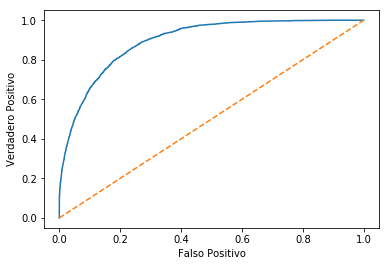

In [35]:
false_positive, true_positive, thres = roc_curve(y_test,yhat_prob)
plt.plot(false_positive,true_positive)
plt.ylabel('Verdadero Positivo')
plt.xlabel('Falso Positivo')
plt.plot([0,1],ls='--')

In [36]:
roc_auc_score(y_test,yhat_prob)

0.8953841782685563

In [37]:
print(confusion_matrix(y_test,yhat))

[[10399   855]
 [ 1536  2134]]


# Modelo predictivo sin standar scaler

In [38]:
x_ = df.loc[:,lista]
y_ = df['income']
x_train,x_test,y_train,y_test = train_test_split(x_,y_,test_size=.33,random_state=123)
modelo = LogisticRegression().fit(x_train,y_train)
yhat =modelo.predict(x_test)
yhat_prob =modelo.predict_proba(x_test)[:,1]
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     11254
           1       0.72      0.58      0.64      3670

    accuracy                           0.84     14924
   macro avg       0.80      0.75      0.77     14924
weighted avg       0.83      0.84      0.84     14924



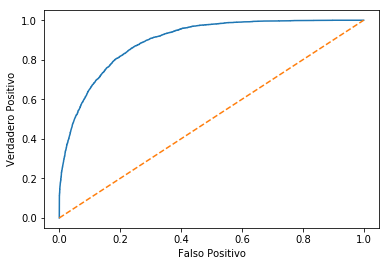

In [39]:
false_positive, true_positive, thres = roc_curve(y_test,yhat_prob)
plt.plot(false_positive,true_positive)
plt.ylabel('Verdadero Positivo')
plt.xlabel('Falso Positivo')
plt.plot([0,1],ls='--')

# Modelo saturado

In [40]:
lista = list(df_saturado.columns)
lista.remove('income')
x_ = df_saturado.loc[:,lista]
y_ = df_saturado['income']
x_train,x_test,y_train,y_test = train_test_split(x_,y_,test_size=.33,random_state=123)
modelo = LogisticRegression().fit(x_train,y_train)
yhat =modelo.predict(x_test)
yhat_prob =modelo.predict_proba(x_test)[:,1]
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     11254
           1       0.71      0.58      0.64      3670

    accuracy                           0.84     14924
   macro avg       0.79      0.75      0.77     14924
weighted avg       0.83      0.84      0.83     14924



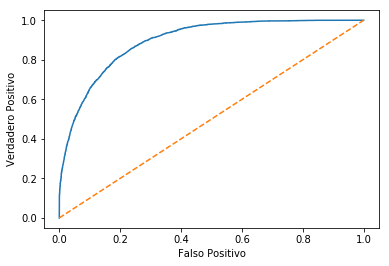

In [41]:
false_positive, true_positive, thres = roc_curve(y_test,yhat_prob)
plt.plot(false_positive,true_positive)
plt.ylabel('Verdadero Positivo')
plt.xlabel('Falso Positivo')
plt.plot([0,1],ls='--')

# Conclusiones

Se observa que el rendimiento del modelo predictivo es alto, esto es visible en la matriz de confusion, a la vez en modelo depurado es simil al modelo sin depurar en rendimiento, lo que significa que las columnas escogidas para el modelo depurado son significativas, a su vez la curva roc tambien defiende la valides del modelo, por lo que se concluye que el modelo es correcto para predecir bajo condiciones similares a las del dataframe